# Recommender Systems 2017/18

### Practice 7 - SGD-based Learning for Factorization Machines

S. Rendle, "**Factorization Machines with libFM**," ACM Trans. Intell. Syst. Technol., 3(3), May 2012.

##### The original version of this notebook is available at [Takuti Github repo](https://github.com/takuti/factorization-machines)

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from SGD_FM import Regression, Classification

### Utility functions

In [3]:
def plot(l, xlabel, ylabel):
    fig, ax = plt.subplots()
    ax.plot(range(len(l)), l)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    fig.set_size_inches((5.5,3))
    fig.patch.set_alpha(0.0)

### Regression: Mock dataset

In [4]:
X = np.array([
    [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0.5, 0.5],
    [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0.5, 0, 0.5],
    [0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0.5, 0.5, 0]
    ])
y = np.array([5, 3, 1, 4, 5, 1, 5])

n_sample = y.size

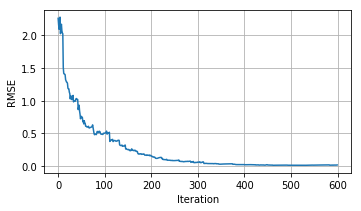

In [5]:
# learn incrementally
regressor = Regression(X, y)

RMSEs = []
for i in range(600):
    # update with randomly sampled one
    j = np.random.randint(n_sample)
    RMSE = regressor.update(X[j], y[j])
    RMSEs.append(RMSE)
    
plot(RMSEs, 'Iteration', 'RMSE')

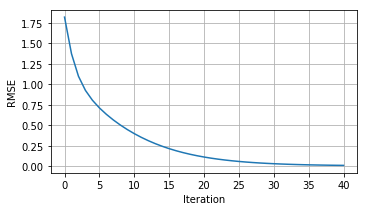

In [6]:
# learn at once
# 1 iteration = descent for all samples
regressor = Regression(X, y)
RMSEs = regressor.fit()
plot(RMSEs, 'Iteration', 'RMSE')

## Classification: Based on the mock dataset

In [7]:
# give labels for the mock dataset
y_labels = np.ones_like(y)
y_labels[y < np.mean(y)] = -1
y_labels

array([ 1, -1, -1,  1,  1, -1,  1])

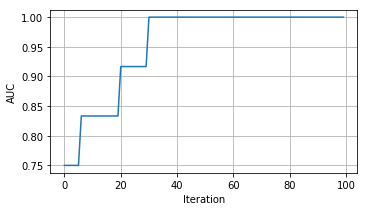

In [8]:
# learn incrementally
classifier = Classification(X, y_labels)

AUCs = []
for i in range(100):
    # update with random sample
    j = np.random.randint(n_sample)
    current = classifier.update(X[j], y_labels[j])
    AUCs.append(current)

plot(AUCs, 'Iteration', 'AUC')

### Let's look at the code

In [9]:
from abc import ABCMeta, abstractmethod
import numpy as np
from sklearn import metrics

class SGD:
    __metaclass__ = ABCMeta

    def __init__(self, X, y, l2_reg_w0=0.01, l2_reg_w=0.01, l2_reg_V=0.01, learn_rate=0.01):
        self.X, self.y = X, y
        self.n, self.p = X.shape # number of samples and their dimension

        # parameter settings
        self.k = int(np.sqrt(self.p)) # for the low-rank assumption of pairwise interaction
        self.l2_reg_w0 = l2_reg_w0
        self.l2_reg_w = l2_reg_w
        self.l2_reg_V = l2_reg_V
        self.learn_rate = learn_rate

        # initialize the model parameters
        # we have the weight vector and the pairwise interaction matrix
        self.w0 = 0.
        self.w = np.zeros(self.p)
        self.V = np.random.random((self.p, self.k))

    def predict(self, x):
        """
        Return a predicted value for an input vector x.
        """

        # efficient vectorized implementation of the pairwise interaction term
        interaction = float(np.sum(np.dot(self.V.T, np.array([x]).T) ** 2 - 
                                   np.dot(self.V.T ** 2, np.array([x]).T ** 2)) / 2.)

        # Add the pairwise interaction to the linear weight
        return self.w0 + np.inner(self.w, x) + interaction

    def fit(self):
        """
        Learn the model parameters with SGD. Iterate until convergence.
        """

        prev = float('inf')
        current = 0.
        eps = 1e-3

        history = []
        while abs(prev - current) > eps:
            prev = current
            for x, y in zip(self.X, self.y): # for each (x, y) training sample
                current = self.update(x, y)
            history.append(current)
        return history

    def update(self, x, y):
        """
        Update the model parameters based on the given vector-value pair.
        """

        # common part of the gradient
        grad_base = self._loss_derivative(x, y)

        grad_w0 = grad_base * 1.
        self.w0 = self.w0 - self.learn_rate * (grad_w0 + 2. * self.l2_reg_w0 * self.w0)

        # Update every paramether
        for i in range(self.p):
            if x[i] == 0.: continue
            grad_w = grad_base * x[i]
            self.w[i] = self.w[i] - self.learn_rate * (grad_w + 2. * self.l2_reg_w * self.w[i])

            for f in range(self.k):
                grad_V = grad_base * x[i] * (sum(x * self.V[:, f]) - x[i] * self.V[i, f])
                self.V[i, f] = self.V[i, f] - \
                                self.learn_rate * (grad_V + 2. * self.l2_reg_V * self.V[i, f])

        return self._evaluate()

    @abstractmethod
    def _loss_derivative(self, x, y):
        # for grad_base
        pass

    @abstractmethod
    def _evaluate(self):
        # RMSE for regression
        # AUC for classification
        pass

In [10]:

class Regression(SGD):
    def _loss_derivative(self, x, y):
        return 2. * (self.predict(x) - y)

    def _evaluate(self):
        # Efficient vectorized RMSE computation
        linear = np.dot(self.X, np.array([self.w]).T).T
        interaction = np.array([np.sum(np.dot(self.X, self.V) ** 2 - np.dot(self.X ** 2, self.V ** 2), axis=1) / 2.])
        y_pred = self.w0 + linear + interaction
        y_pred = y_pred.reshape((self.n))

        return metrics.mean_squared_error(self.y, y_pred) ** 0.5


In [11]:

class Classification(SGD):
    def _loss_derivative(self, x, y):
        return (1. / (1. + np.e ** (- self.predict(x) * y)) - 1) * y

    def _evaluate(self):
        linear = np.dot(self.X, np.array([self.w]).T).T
        interaction = np.array([np.sum(np.dot(self.X, self.V) ** 2 - np.dot(self.X ** 2, self.V ** 2), axis=1) / 2.])
        y_pred = self.w0 + linear + interaction
        y_pred = y_pred.reshape((self.n))

        fpr, tpr, thresholds = metrics.roc_curve(self.y, y_pred, pos_label=1)
        return metrics.auc(fpr, tpr)
